# Convert and Optimize YOLOv8 instance segmentation model with OpenVINO™

Instance segmentation goes a step further than object detection and involves identifying individual objects in an image and segmenting them from the rest of the image. Instance segmentation as an object detection are often used as key components in computer vision systems. 
Applications that use real-time instance segmentation models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for instance segmentation scenario.

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.
- Live demo


#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Check model accuracy on the dataset](#Check-model-accuracy-on-the-dataset)
    - [Download the validation dataset](#Download-the-validation-dataset)
    - [Define validation function](#Define-validation-function)
    - [Configure Validator helper and create DataLoader](#Configure-Validator-helper-and-create-DataLoader)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance of the Original and Quantized Models](#Compare-performance-of-the-Original-and-Quantized-Models)
    - [Validate quantized model accuracy](#Validate-quantized-model-accuracy)
- [Other ways to optimize model](#Other-ways-to-optimize-model)
- [Live demo](#Live-demo)
    - [Run Live Object Detection and Segmentation](#Run-Live-Object-Detection-and-Segmentation)



## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [ ]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0"
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.1.42" onnx --extra-index-url https://download.pytorch.org/whl/cpu

Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests
r = requests.get(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py',
)

open('notebook_utils.py', 'w').write(r.text)
from notebook_utils import download_file, VideoPlayer

In [3]:
# Download a test sample
IMAGE_PATH = Path('./data/coco_bike.jpg')
download_file(
    url='https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg',
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent
) 

data/coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

PosixPath('/home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/data/coco_bike.jpg')

## Instantiate model
[back to top ⬆️](#Table-of-contents:)

For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model and boxes and masks for segmentation model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [4]:
models_dir = Path('./models')
models_dir.mkdir(exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████| 6.73M/6.73M [00:01<00:00, 3.89MB/s]



image 1/1 /home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/data/coco_bike.jpg: 480x640 1 bicycle, 2 cars, 1 dog, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


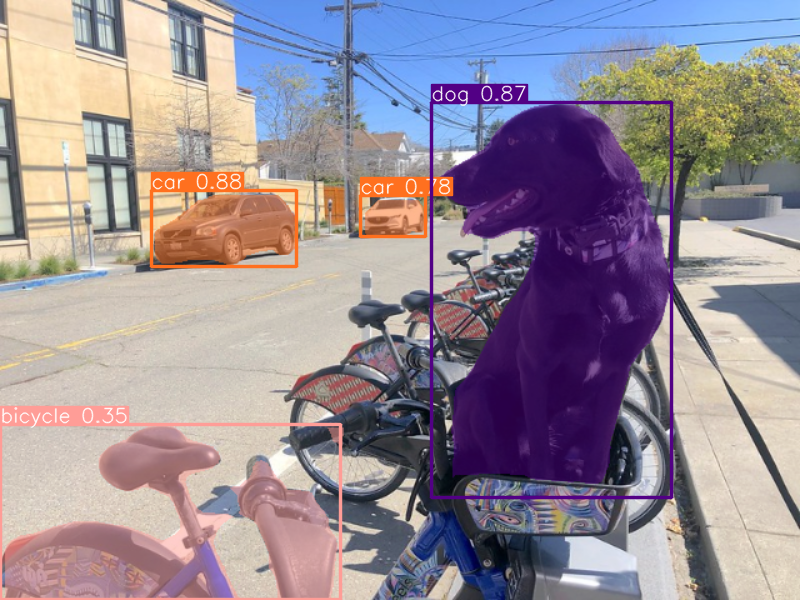

In [5]:
from PIL import Image
from ultralytics import YOLO

SEG_MODEL_NAME = "yolov8n-seg"

seg_model = YOLO(models_dir / f'{SEG_MODEL_NAME}.pt')
label_map = seg_model.model.names

res = seg_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [6]:
# instance segmentation model
seg_model_path = models_dir / f"{SEG_MODEL_NAME}_openvino_model/{SEG_MODEL_NAME}.xml"
if not seg_model_path.exists():
    seg_model.export(format="openvino", dynamic=True, half=True)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.2+cpu CPU (Intel Core(TM) i9-10980XE 3.00GHz)

PyTorch: starting from 'models/yolov8n-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (6.7 MB)

OpenVINO: starting export with openvino 2024.0.0-14509-34caeefd078-releases/2024/0...
OpenVINO: export success ✅ 1.8s, saved as 'models/yolov8n-seg_openvino_model/' (6.9 MB)

Export complete (3.0s)
Results saved to /home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/models
Predict:         yolo predict task=segment model=models/yolov8n-seg_openvino_model imgsz=640 half 
Validate:        yolo val task=segment model=models/yolov8n-seg_openvino_model imgsz=640 data=coco.yaml half 
Visualize:       https://netron.app


### Verify model inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline for pre- and postprocessing just replacing the inference method where we will use the IR model for inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets
import openvino as ov 

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

In [8]:
core = ov.Core()
seg_ov_model = core.read_model(seg_model_path)

ov_config = {}
if device.value != "CPU":
    seg_ov_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
seg_compiled_model = core.compile_model(seg_ov_model, device.value, ov_config)

In [9]:
import torch

def infer(*args):
    result = seg_compiled_model(args)
    return torch.from_numpy(result[0]), torch.from_numpy(result[1])

seg_model.predictor.inference = infer
seg_model.predictor.model.pt = False


image 1/1 /home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/data/coco_bike.jpg: 640x640 1 bicycle, 2 cars, 1 dog, 27.6ms
Speed: 3.5ms preprocess, 27.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


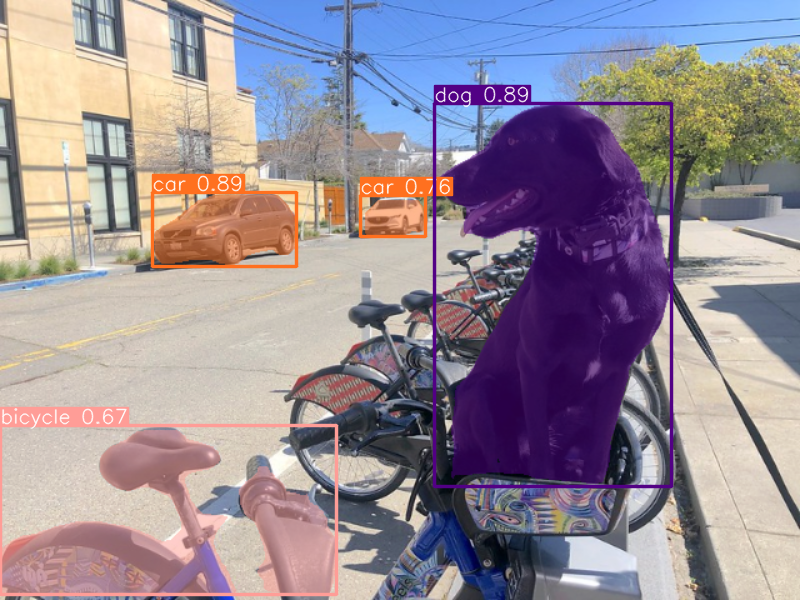

In [10]:
res = seg_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

Great! The result is the same, as produced by original models.

## Check model accuracy on the dataset
[back to top ⬆️](#Table-of-contents:)

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset. 


### Download the validation dataset
[back to top ⬆️](#Table-of-contents:)

YOLOv8 is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

>**Note**: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

In [ ]:
from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

OUT_DIR = DATASETS_DIR

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

### Define validation function
[back to top ⬆️](#Table-of-contents:)


In [12]:
import numpy as np
from tqdm.notebook import tqdm
from ultralytics.utils.metrics import ConfusionMatrix


def test(model:ov.Model, core:ov.Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = dict(tp_m=[], tp=[], conf=[], pred_cls=[], target_cls=[])
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    num_outputs = len(model.outputs)
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        if num_outputs == 1:
            preds = torch.from_numpy(results[compiled_model.output(0)])
        else:
            preds = [torch.from_numpy(results[compiled_model.output(0)]), torch.from_numpy(results[compiled_model.output(1)])]
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    print("    Best mean average:")
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        # Print results
        print("    Macro average mean:")
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

### Configure Validator helper and create DataLoader
[back to top ⬆️](#Table-of-contents:)

The original model repository uses a `Validator` wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the `ValidatorClass` method, which creates a validator class instance.

In [13]:
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset
from ultralytics.utils import ops

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [14]:
seg_validator = seg_model.task_map[seg_model.task]['validator'](args=args)
seg_validator.data = check_det_dataset(args.data)
seg_validator.stride = 32
seg_data_loader = seg_validator.get_dataloader(OUT_DIR / "coco/", 1)

seg_validator.is_coco = True
seg_validator.class_map = coco80_to_coco91_class()
seg_validator.names = seg_model.model.names
seg_validator.metrics.names = seg_validator.names
seg_validator.nc = seg_model.model.model[-1].nc
seg_validator.nm = 32
seg_validator.process = ops.process_mask
seg_validator.plot_masks = []

val: Scanning /home/maleksandr/test_notebooks/ultrali/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds,


After definition test function and validator creation, we are ready for getting accuracy metrics
>**Note**: Model evaluation is time consuming process and can take several minutes, depending on the hardware. For reducing calculation time, we define `num_samples` parameter with evaluation subset size, but in this case, accuracy can be noncomparable with originally reported by the authors of the model, due to validation subset difference.
*To validate the models on the full dataset set `NUM_TEST_SAMPLES = None`.*

In [15]:
NUM_TEST_SAMPLES = 300

In [16]:
fp_seg_stats = test(seg_ov_model, core, seg_data_loader, seg_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [17]:
print_stats(fp_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.609       0.521        0.58       0.416
    Macro average mean:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.605       0.501       0.558       0.353


`print_stats` reports the following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where `t` is the Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, `mAP@.5` indicates that mean average precision is calculated at 0.5 IOU threshold, `mAP@.5:.95` - is calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [18]:
import ipywidgets as widgets

int8_model_seg_path = models_dir / f'{SEG_MODEL_NAME}_openvino_int8_model/{SEG_MODEL_NAME}.xml'

to_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [19]:
# Fetch skip_kernel_extension module
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/master/notebooks/utils/skip_kernel_extension.py',
    filename='skip_kernel_extension.py'
)

%load_ext skip_kernel_extension

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [20]:
%%skip not $to_quantize.value


import nncf
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = seg_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(seg_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [21]:
%%skip not $to_quantize.value

ignored_scope = nncf.IgnoredScope(
    names=[
        "__module.model.22.cv3.0.0.conv/aten::_convolution/Convolution",  # in the post-processing subgraph
    	"__module.model.22.proto.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv4.0.0.conv/aten::_convolution/Convolution",
    	"__module.model.16.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv2.0.0.conv/aten::_convolution/Convolution",
    	"__module.model.6.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv3.1.1.conv/aten::_convolution/Convolution",
    	"__module.model.21.cv2.conv/aten::_convolution/Convolution",
    	"__module.model.21.m.0.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.22/aten::add/Add_6",
    	"__module.model.22/aten::sub/Subtract",
    	"__module.model.7.conv/aten::_convolution/Convolution",
    	"__module.model.12.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.4.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv2.2.1.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv2.0.1.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv4.2.1.conv/aten::_convolution/Convolution",
    	"__module.model.22.dfl.conv/aten::_convolution/Convolution",
    	"__module.model.22.cv3.2.2/aten::_convolution/Convolution",
    	"__module.model.22.cv3.0.2/aten::_convolution/Convolution",
    	"__module.model.15.cv1.conv/aten::_convolution/Convolution",
    	"__module.model.5.conv/aten::_convolution/Convolution",
    	"__module.model.0.conv/aten::_convolution/Convolution"
    ]
)

# Detection model
quantized_seg_model = nncf.quantize(
    seg_ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

INFO:nncf:23 ignored nodes were found by name in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 1 __module.model.0.conv/aten::_convolution/Convolution
2 __module.model.0.conv/aten::_convolution/Add
3 __module.model.22.cv4.2.1.act/aten::silu_/Swish

INFO:nncf:Not adding activation input quantizer for operation: 25 __module.model.4.cv1.conv/aten::_convolution/Convolution
26 __module.model.4.cv1.conv/aten::_convolution/Add
27 __module.model.22.cv4.2.1.act/aten::silu_/Swish_7

INFO:nncf:Not adding activation input quantizer for operation: 43 __module.model.5.conv/aten::_convolution/Convolution
47 __module.model.5.conv/aten::_convolution/Add
51 __module.model.22.cv4.2.1.act/aten::silu_/Swish_13

INFO:nncf:Not adding activation input quantizer for operation: 54 __module.model.6.cv1.conv/aten::_convolution/Convolution
56 __module.model.6.cv1.conv/aten::_convolution/Add
59 __module.model.22.cv4.2.1.act/aten::silu_/Swish_14

INFO:nncf:Not adding activation input qu

Output()

/home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/venv/lib/python3.10/site-packages/nncf/experimental/tensor/tensor.py:84: RuntimeWarning: invalid value encountered in multiply
  return Tensor(self.data * unwrap_tensor_data(other))


Output()

In [22]:
%%skip not $to_quantize.value

print(f"Quantized segmentation model will be saved to {int8_model_seg_path}")
ov.save_model(quantized_seg_model, str(int8_model_seg_path))

Quantized segmentation model will be saved to models/yolov8n-seg_openvino_int8_model/yolov8n-seg.xml


### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [23]:
%%skip not $to_quantize.value

device

In [24]:
%%skip not $to_quantize.value

ov_config = {}
if device.value != "CPU":
    quantized_seg_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

quantized_seg_compiled_model = core.compile_model(quantized_seg_model, device.value, ov_config)

In [25]:
%%skip not $to_quantize.value


def infer(*args):
    result = quantized_seg_compiled_model(args)
    return torch.from_numpy(result[0]), torch.from_numpy(result[1])

seg_model.predictor.inference = infer


image 1/1 /home/maleksandr/test_notebooks/update_ultralytics/openvino_notebooks/notebooks/yolov8-optimization/data/coco_bike.jpg: 640x640 1 bicycle, 2 cars, 2 dogs, 26.8ms
Speed: 2.8ms preprocess, 26.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


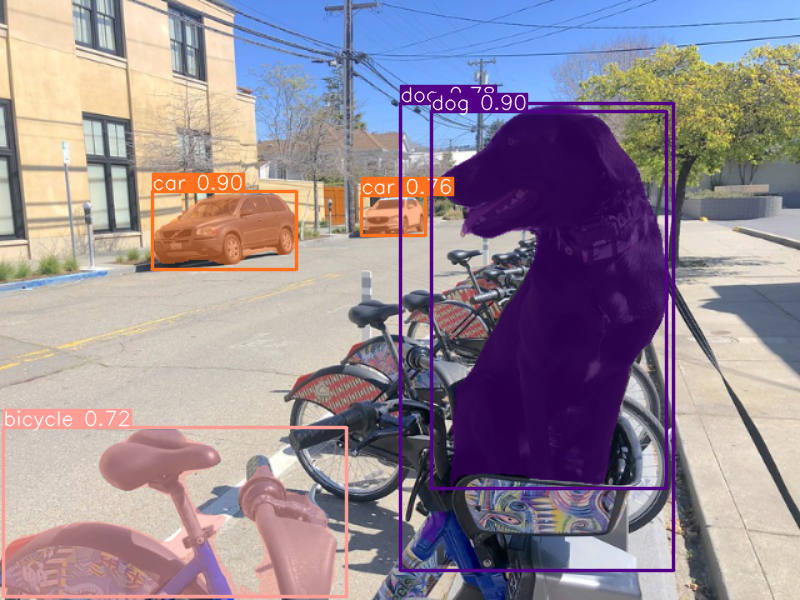

In [26]:
%%skip not $to_quantize.value

res = seg_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [27]:
%%skip not $to_quantize.value

device

In [28]:
if int8_model_seg_path.exists():
    !benchmark_app -m $seg_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 15.84 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_8) : f32 / [...] / [?,116,16..]
[ INFO ]     input.199 (node: __module.model.22.cv4.2.1.act/aten::silu_/Swish_37) : f3

In [29]:
if int8_model_seg_path.exists():
    !benchmark_app -m $int8_model_seg_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 24.33 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_8) : f32 / [...] / [1,116,21..]
[ INFO ]     input.199 (node: __module.model.22.cv4.2.1.act/aten::silu_/Swish_37) : f3

### Validate quantized model accuracy
[back to top ⬆️](#Table-of-contents:)

As we can see, there is no significant difference between `INT8` and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

In [30]:
%%skip not $to_quantize.value

int8_seg_stats = test(quantized_seg_model, core, seg_data_loader, seg_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [31]:
%%skip not $to_quantize.value

print("FP32 model accuracy")
print_stats(fp_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

FP32 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.609       0.521        0.58       0.416
    Macro average mean:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.605       0.501       0.558       0.353
INT8 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.522       0.538       0.555       0.376
    Macro average mean:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.631       0.463       0.529       0.344


Great! Looks like accuracy was changed, but not significantly and it meets passing criteria.

## Other ways to optimize model
[back to top ⬆️](#Table-of-contents:)

The performance could be also improved by another OpenVINO method such as async inference pipeline or preprocessing API.

Async Inference pipeline help to utilize the device more optimal. The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../async-api/async-api.ipynb)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries. 
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will also improve selected device utilization. For more information, refer to the overview of [Preprocessing API tutorial](../optimize-preprocessing/optimize-preprocessing.ipynb). To see, how it could be used with YOLOV8 object detection model , please, see [Convert and Optimize YOLOv8 real-time object detection with OpenVINO tutorial](./yolov8-object-detection.ipynb)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [32]:
import collections
import time
import cv2
from IPython import display


def run_instance_segmentation(source=0, flip=False, use_popup=False, skip_first_frames=0, model=seg_model, device=device.value):
    player = None

    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0]), torch.from_numpy(result[1])
    
    seg_model.predictor.inference = infer
    
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            detections = seg_model(input_image)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Object Detection and Segmentation
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

In [33]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4'

In [34]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

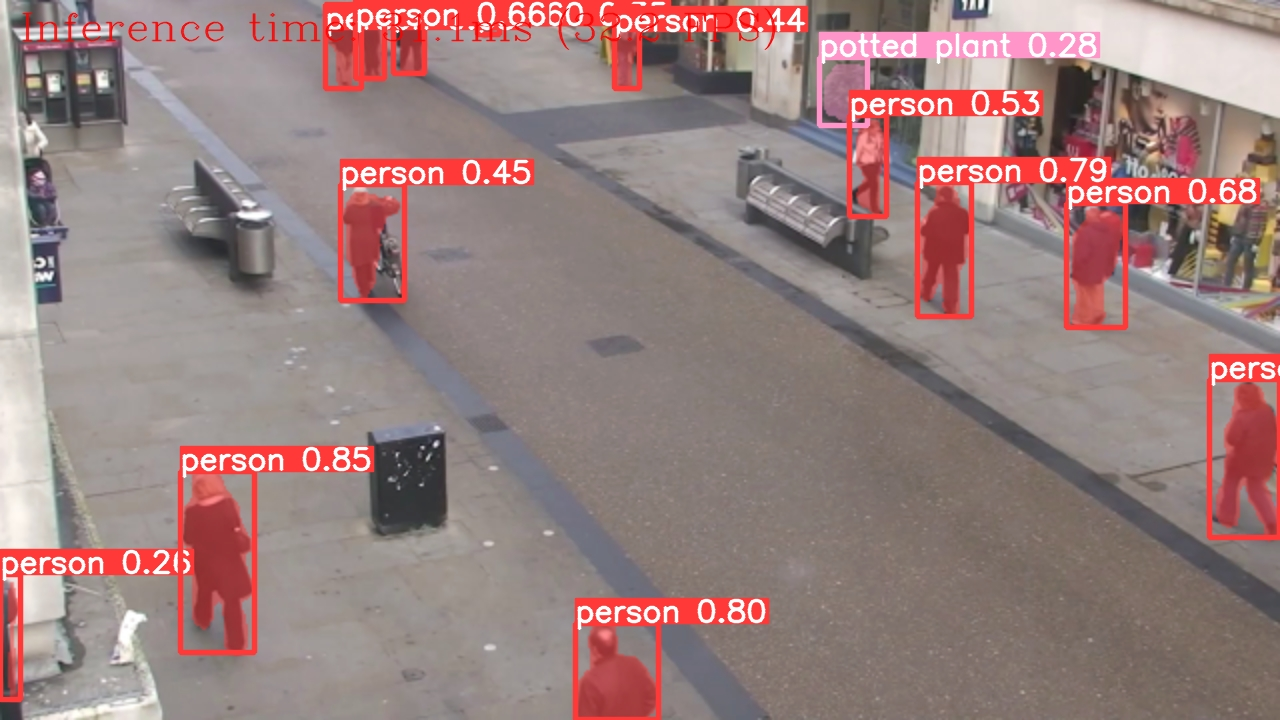

Source ended


In [35]:
run_instance_segmentation(source=VIDEO_SOURCE, flip=True, use_popup=False, model=seg_ov_model, device=device.value)